In [1]:
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

In [32]:
def pre_process(file_name):
  diabetes_data=pd.read_csv(file_name)
  size=len(diabetes_data)

  X=diabetes_data[["Pregnancies" 	,"Glucose" ,	"BloodPressure", 	"SkinThickness", 	"Insulin",	"BMI", 	"DiabetesPedigreeFunction" ,	"Age"]]
  y=diabetes_data[["Outcome"]]

  X_withNaNs=X[["Pregnancies" 	,"Glucose" ,	"BloodPressure", 	"SkinThickness", 	"Insulin",	"BMI", 	"DiabetesPedigreeFunction" ,	"Age"]].replace({0: np.nan}, inplace=False)
  # https://scikit-learn.org/stable/modules/impute.html
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(X_withNaNs)
  X_uni_impute=imp.transform(X_withNaNs)

  df=pd.DataFrame(X_uni_impute)
  col_names = list(df)
  outlier_indices = []
  for i in col_names:
      Q1 = np.quantile(df[i],0.25)
      Q3 = np.quantile(df[i],0.75)
      IQR = Q3 - Q1

      lower_range = Q1 - 1.5 * IQR
      upper_range = Q3 + 1.5 * IQR
      for j in range(0,(df.shape[0])):
          if (df[i][j] < lower_range) or (df[i][j] > upper_range):
              # print("out_ind",outlier_indices)        
              outlier_indices.append(j)
      
      if outlier_indices!=[]:
          outlier_indices = list(set(outlier_indices))
  outlier_indices.sort()
  data_new = df[[i not in outlier_indices for i in range(0,df.shape[0])]]
  outlier_removed_mean_X=data_new
  outlier_removed_y=pd.DataFrame(y)[[i not in outlier_indices for i in range(0,df.shape[0])]]
  size=len(outlier_removed_y)
  train_X=outlier_removed_mean_X[0:math.floor(0.8*size)]

  scaler = preprocessing.StandardScaler().fit(train_X)
  outlier_removed_mean_scaled_X=scaler.transform(outlier_removed_mean_X)
  outlier_removed_not_scaled_y=outlier_removed_y
  outlier_removed_mean_scaled_X=pd.DataFrame(outlier_removed_mean_scaled_X)
  outlier_removed_mean_scaled_X.columns =["Pregnancies" 	,"Glucose" ,	"BloodPressure", 	"SkinThickness", 	"Insulin",	"BMI", 	"DiabetesPedigreeFunction" ,	"Age"]

  outlier_removed_mean_scaled_X=pd.DataFrame(outlier_removed_mean_scaled_X)
  outlier_removed_mean_scaled_X.columns =["Pregnancies" 	,"Glucose" ,	"BloodPressure", 	"SkinThickness", 	"Insulin",	"BMI", 	"DiabetesPedigreeFunction" ,	"Age"]

  data=outlier_removed_mean_scaled_X[["Glucose","SkinThickness","DiabetesPedigreeFunction","Age"]]

  return (scaler,data,outlier_removed_not_scaled_y)

In [33]:
def split_data(data,outlier_removed_not_scaled_y):
  size=len(data)
  train_X=data[0:math.floor(0.8*size)]
  train_y=outlier_removed_not_scaled_y[0:math.floor(0.8*size)]
  test_X=data[math.floor(0.8*size):math.floor(size)]
  test_y=outlier_removed_not_scaled_y[math.floor(0.8*size):math.floor(size)]
  return (train_X,train_y,test_X,test_y)

In [34]:

def train_test_score(train_X,train_y,test_X,test_y):
  from sklearn import svm
  from sklearn.metrics import classification_report, confusion_matrix

  param_grid = {'C': [0.0001,0.001,0.01,0.1, 1, 10, 100, 1000,10000],

                'gamma': [1000,100,10,1, 0.1, 0.01, 0.001, 0.0001,0.00001,0.000001,0.0000001,1e-07,1e-08,1e-09,1e-010,1e-011],

                'kernel': ['rbf']}

  grid = GridSearchCV(svm.SVC(class_weight="balanced",cache_size=100000), param_grid, refit = True, verbose = 3,n_jobs=10)

  grid.fit(train_X, train_y)
  from sklearn.metrics import accuracy_score
  cf_matrix = confusion_matrix(test_y, grid.predict(test_X))

  from sklearn.metrics import classification_report, confusion_matrix
  print(classification_report(train_y,  grid.predict(train_X)))


  import seaborn as sns
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  return grid


Fitting 5 folds for each of 144 candidates, totalling 720 fits
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       269
           1       0.62      0.57      0.59       137

    accuracy                           0.74       406
   macro avg       0.70      0.70      0.70       406
weighted avg       0.73      0.74      0.73       406



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


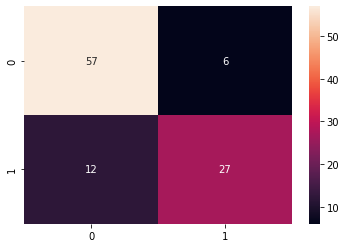

In [35]:
file_name="/content/drive/MyDrive/diabetes.csv"
(scaler,X,y)=pre_process(file_name)
(train_X,train_y,test_X,test_y)=split_data(X,y)
clf=train_test_score(train_X,train_y,test_X,test_y)

In [45]:
def forecast(scaler,clf,Glucose,SkinThickness,DiabetesPedigreeFunction,Age):
  transformed=scaler.transform([[0,Glucose,0,SkinThickness,0,0,DiabetesPedigreeFunction,Age]])[0]
  df=pd.DataFrame([[transformed[1],transformed[3],transformed[6],transformed[7]]],columns=["Glucose","SkinThickness","DiabetesPedigreeFunction","Age"])
  if clf.predict(df)[0]==1:
    print("Likely to be diabetic in the next 5 years")
  else:
    print("Unlikely to be diabetic in the next 5 years")

In [46]:
forecast(scaler,clf,148,35,0.627,50)

Likely to be diabetic in the next 5 years
